# demo.ipynb を改変

ここでは、

アノテーション（point, bbox, mask）全てを画像で与えるコードを作成する

demo.ipynbではpoint, bboxは座標としてコードの中で明示的に与えられていた。


# マスクも含めて “すべて JSON” から読む版のフルコードです。
マスクは JSON 内で RLE（COCO形式）または polygons で与えられる想定にしました（PNG等の外部画像は使いません）。RLE を使う場合は pycocotools が必要です。

In [2]:
from pathlib import Path
import json
import numpy as np
import cv2

def _mask_from_polygons(size_hw, polygons):
    H, W = int(size_hw[0]), int(size_hw[1])
    m = np.zeros((H, W), dtype=np.uint8)
    for poly in polygons or []:
        if not poly: 
            continue
        pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
        pts = np.round(pts).astype(np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m

def _mask_from_rle(size_hw, counts):
    try:
        from pycocotools import mask as mask_utils
    except Exception:
        raise RuntimeError("RLEを読むには pycocotools が必要です（pip install pycocotools）")
    rle = {"size": [int(size_hw[0]), int(size_hw[1])], "counts": counts}
    m = mask_utils.decode(rle)
    if m.ndim == 3:
        m = m[..., 0]
    return (m.astype(np.uint8) * 255)

def load_ann_any_json(json_path: Path, expected_stem: str | None = None, verbose: bool = True):
    """
    json_path を直接指定して読み込む。COCO形式 / 簡易形式どちらも対応。
    expected_stem を与えると、COCOの images[].file_name と照合し、見つからなければフォールバック。
    返り値: {'bboxes':{cid:[[x1,y1,x2,y2],...]}, 'points':{cid:[[x,y],...]}, 'masks':{cid:[np.ndarray(H,W),...]}}
    """
    out = {"bboxes": {}, "points": {}, "masks": {}}
    if not json_path.exists():
        if verbose: print(f"[ann] not found:", json_path)
        return out

    data = json.load(open(json_path, "r", encoding="utf-8"))
    is_coco = all(k in data for k in ("images","categories","annotations"))

    # --- 簡易形式 ---
    if not is_coco:
        for k in ("bboxes","points"):
            raw = data.get(k, {})
            if isinstance(raw, dict):
                for cid, arr in raw.items():
                    try: cid = int(cid)
                    except: continue
                    if isinstance(arr, list):
                        out[k].setdefault(cid, []).extend(arr)
        raw_masks = data.get("masks", {})
        if isinstance(raw_masks, dict):
            for cid, entries in raw_masks.items():
                try: cid = int(cid)
                except: continue
                for entry in (entries or []):
                    fmt = str(entry.get("format","")).lower()
                    size = entry.get("size", None)
                    if not size: 
                        continue
                    if fmt == "polygons":
                        m = _mask_from_polygons(size, entry.get("polygons", []))
                        out["masks"].setdefault(cid, []).append(m)
                    elif fmt == "rle":
                        m = _mask_from_rle(size, entry.get("counts"))
                        out["masks"].setdefault(cid, []).append(m)
        if verbose:
            tb = sum(len(v) for v in out["bboxes"].values())
            tp = sum(len(v) for v in out["points"].values())
            tm = sum(len(v) for v in out["masks"].values())
            print(f"[simple] {json_path.name} → bbox:{tb} point:{tp} mask:{tm}")
        return out

    # --- COCO形式 ---
    images = data.get("images", [])
    anns   = data.get("annotations", [])
    img_entry = None

    # 1) stem完全一致
    if expected_stem is not None:
        for im in images:
            fn = str(im.get("file_name",""))
            if Path(fn).stem == expected_stem:
                img_entry = im; break

    # 2) フォールバック: 1枚だけならそれを採用
    if img_entry is None and len(images) == 1:
        img_entry = images[0]

    # 3) フォールバック: 部分一致
    if img_entry is None and expected_stem is not None:
        for im in images:
            if expected_stem in Path(str(im.get("file_name",""))).stem:
                img_entry = im; break

    if img_entry is None:
        if verbose:
            print(f"[coco] no image matched. expected_stem={expected_stem} available={[im.get('file_name') for im in images]}")
        return out

    image_id = img_entry["id"]
    H, W = int(img_entry.get("height", 0)), int(img_entry.get("width", 0))
    target_anns = [a for a in anns if a.get("image_id") == image_id]

    def add(dic, cid, v): dic.setdefault(int(cid), []).append(v)

    for a in target_anns:
        cid = int(a.get("category_id"))
        # bbox [x,y,w,h]→[x1,y1,x2,y2]
        if "bbox" in a and isinstance(a["bbox"], (list,tuple)) and len(a["bbox"])==4:
            x,y,w,h = a["bbox"]
            x1,y1,x2,y2 = float(x), float(y), float(x)+float(w), float(y)+float(h)
            if x2>x1 and y2>y1:
                add(out["bboxes"], cid, [x1,y1,x2,y2])
        # keypoints → points
        if "keypoints" in a and isinstance(a["keypoints"], list) and len(a["keypoints"])>=3:
            kps = a["keypoints"]
            for i in range(0,len(kps),3):
                xk, yk, v = kps[i], kps[i+1], kps[i+2]
                if v and xk is not None and yk is not None:
                    add(out["points"], cid, [float(xk), float(yk)])
        # segmentation → masks
        seg = a.get("segmentation", None)
        if seg is not None:
            # RLE
            if isinstance(seg, dict) and "counts" in seg and "size" in seg:
                m = _mask_from_rle(seg["size"], seg["counts"])
                add(out["masks"], cid, m)
            elif isinstance(seg, list) and seg and isinstance(seg[0], dict) and "counts" in seg[0]:
                for r in seg:
                    m = _mask_from_rle(r["size"], r["counts"])
                    add(out["masks"], cid, m)
            # polygons（★空リストは無視！）
            elif isinstance(seg, list) and len(seg)>0:
                m = _mask_from_polygons([H,W], seg)
                if (m>0).any():
                    add(out["masks"], cid, m)

    # 全ゼロマスク除外（保険）
    for cid, arrs in list(out["masks"].items()):
        out["masks"][cid] = [m for m in arrs if isinstance(m, np.ndarray) and (m>0).any()]

    if verbose:
        tb = sum(len(v) for v in out["bboxes"].values())
        tp = sum(len(v) for v in out["points"].values())
        tm = sum(len(v) for v in out["masks"].values())
        print(f"[coco] {json_path.name} (use file_name={img_entry.get('file_name')}) → bbox:{tb} point:{tp} mask:{tm}")
    return out


In [3]:
from pathlib import Path

ANNOT_DIR = Path.cwd() / "annotations"   # 実際の場所に合わせて
json_path = ANNOT_DIR / "image02.json"   # ここを確認
ann = load_ann_any_json(json_path, expected_stem="image02", verbose=True)

print("b:", sum(len(v) for v in ann["bboxes"].values()),
      "p:", sum(len(v) for v in ann["points"].values()),
      "m:", sum(len(v) for v in ann["masks"].values()))
for k in ("bboxes","points","masks"):
    print(k, {cid: len(v) for cid, v in ann[k].items()})


[coco] image02.json (use file_name=image02.png) → bbox:1 point:14 mask:1
b: 1 p: 14 m: 1
bboxes {3: 1}
points {1: 7, 2: 7}
masks {3: 1}


In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))

import os
import json
from typing import Dict, List, Tuple, Any

from PIL import Image
import numpy as np
import cv2
import torch

# Pretty visualizations of tensors
import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo
from torchvision.transforms.functional import resize

from accelerate import Accelerator
from label_anything import LabelAnything
from label_anything.data import get_preprocessing, utils
from label_anything.data.transforms import PromptsProcessor

# -----------------------------
# 可視化ユーティリティ
# -----------------------------
colors = [
    (255, 255, 0),   # yellow
    (255, 0, 0),     # red
    (0, 255, 0),     # green
    (0, 0, 255),     # blue
    (255, 0, 255),   # purple
    (0, 255, 255),   # cyan
    (255, 165, 0),   # orange
    (255, 192, 203), # pink
    (139, 69, 19),   # brown
    (128, 128, 128), # grey
    (0, 0, 0),       # black
] * 3

def draw_masks(img: Image.Image, masks: torch.Tensor, colors):
    masked_image = resize(img.copy(), 256)
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

def draw_boxes(img: Image.Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = map(int, box)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

def draw_points(img: Image.Image, points: torch.Tensor, colors):
    img = np.array(img)
    for i, cat in enumerate(points):
        for point in cat:
            x, y = map(int, point)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

def draw_all(img: Image.Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

def get_image(image_tensor: torch.Tensor) -> Image.Image:
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

def dict_to_device(d, device):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = v.to(device)
        elif isinstance(v, dict):
            d[k] = dict_to_device(v, device)
        elif isinstance(v, list):
            d[k] = [dict_to_device(vv, device) for vv in v]
    return d

# -----------------------------
# すべて JSON 読み込み関連（RLE/Polygonをサポート）
# -----------------------------
ANNOT_DIR = Path.cwd() / "annotations"
CLASS_NAME_TO_ID = {
    "handrail": 1,
    "midrail": 2,
    "baseboard": 3,
    # 日本語名を使うならここに追記可
    "手すり": 1,
    "中桟": 2,
    "巾木": 3,
}

try:
    from pycocotools import mask as mask_utils
except Exception:
    mask_utils = None

def _parse_class_key(k: Any, class_map: Dict[str, int]) -> int:
    """
    JSON のクラスキーを int に正規化。
    - 数字文字列や数値は int に
    - 文字列で handrail/midrail/toeboard（または classes で定義）なら対応 ID に
    """
    if isinstance(k, int):
        return k
    if isinstance(k, str):
        ks = k.strip().lower()
        if ks.isdigit():
            return int(ks)
        if ks in class_map:
            return class_map[ks]
    raise ValueError(f"Unsupported class key: {k}")

def _mask_from_polygons(size_hw: List[int], polygons: List[List[float]]) -> np.ndarray:
    """
    polygons: [[x1,y1,x2,y2,...], ...]
    size_hw: [H, W]
    return: 0/255 の 2値マスク (H, W)
    """
    H, W = int(size_hw[0]), int(size_hw[1])
    m = np.zeros((H, W), dtype=np.uint8)
    for poly in polygons:
        if not poly:
            continue
        pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
        pts = np.round(pts).astype(np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m

def _mask_from_rle(size_hw: List[int], counts) -> np.ndarray:
    """
    COCO RLE をデコードして 0/255 の 2値マスクに。
    counts: 圧縮文字列 or 非圧縮リスト（どちらも COCO 互換）
    pycocotools が無ければ RLE は使えない（polygons を使ってください）。
    """
    if mask_utils is None:
        raise RuntimeError(
            "RLE マスクを使うには pycocotools が必要です。`pip install pycocotools` をインストールするか、"
            "JSON の masks を polygons 形式にしてください。"
        )
    rle = {"size": [int(size_hw[0]), int(size_hw[1])], "counts": counts}
    m = mask_utils.decode(rle)  # (H,W) or (H,W,1)
    if m.ndim == 3:
        m = m[..., 0]
    return (m.astype(np.uint8) * 255)

def _load_mask_entry_json(entry: Any) -> np.ndarray:
    """
    entry:
      - {"format":"rle", "size":[H,W], "counts":"<COCO compressed string>"}
      - {"format":"rle", "size":[H,W], "counts":[...]}  # 非圧縮 RLE リスト
      - {"format":"polygons", "size":[H,W], "polygons":[[x1,y1,...], ...]}
    return: 0/255 の 2値マスク (H, W)
    """
    if not isinstance(entry, dict):
        raise ValueError(f"Mask entry must be dict, got {type(entry)}")

    fmt = str(entry.get("format", "")).lower()
    size = entry.get("size", None)
    if not (isinstance(size, (list, tuple)) and len(size) == 2):
        raise ValueError(f"Mask entry missing valid 'size': {entry}")

    if fmt == "polygons":
        polygons = entry.get("polygons", [])
        return _mask_from_polygons(size, polygons)

    if fmt == "rle":
        counts = entry.get("counts", None)
        if counts is None:
            raise ValueError(f"RLE entry missing 'counts': {entry}")
        return _mask_from_rle(size, counts)

    raise ValueError(f"Unsupported mask format: {fmt}")

def load_annotations_for_image(stem: str) -> Dict[str, Dict[int, list]]:
    """
    annotations/<stem>.json を読み込み、
      - 'bboxes' : {class_id: [[x1,y1,x2,y2], ...]}
      - 'points' : {class_id: [[x,y], ...]}
      - 'masks'  : {class_id: [np.ndarray(H,W;0/255), ...]}  ← JSON 内の RLE/Polygon を 2値マスクに変換
    の形で返す。ファイルが無ければ空辞書を返す。
    """
    ann_path = ANNOT_DIR / f"{stem}.json"
    result = {"bboxes": {}, "points": {}, "masks": {}}
    if not ann_path.exists():
        return result

    with open(ann_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # classes があればマージ（優先: ファイル）
    class_map = dict(CLASS_NAME_TO_ID)
    if "classes" in data and isinstance(data["classes"], dict):
        for name, cid in data["classes"].items():
            try:
                class_map[str(name).strip().lower()] = int(cid)
            except Exception:
                pass

    # bboxes / points をクラスIDキーに正規化
    for k in ["bboxes", "points"]:
        raw = data.get(k, {})
        if isinstance(raw, dict):
            for kk, vv in raw.items():
                cid = _parse_class_key(kk, class_map)
                if not isinstance(vv, list):
                    vv = []
                result[k][cid] = vv

    # masks: JSON内の各エントリを実マスク(np.ndarray)に変換
    raw_masks = data.get("masks", {})
    if isinstance(raw_masks, dict):
        for kk, entries in raw_masks.items():
            cid = _parse_class_key(kk, class_map)
            masks_np = []
            if isinstance(entries, list):
                for entry in entries:
                    m = _load_mask_entry_json(entry)
                    if m is not None:
                        masks_np.append(m.astype(np.uint8))
            result["masks"][cid] = masks_np

    return result

def union_class_ids(dicts_per_support: List[Dict[str, Dict[int, list]]]) -> List[int]:
    s = set()
    for d in dicts_per_support:
        for k in ["bboxes", "points", "masks"]:
            s |= set(d.get(k, {}).keys())
    return sorted(list(s))


/Users/rinotsuka/code/papers/LabelAnything/LabelAnything/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

# -----------------------------
# モデル/前処理 準備
# -----------------------------
image_size = 1024
custom_preprocess = True

accelerator = Accelerator(cpu=True)
device = accelerator.device

# Label Anything 本体
la = LabelAnything.from_pretrained("pasqualedem/label_anything_sam_1024_coco")

# 画像ロード
img_dir = Path.cwd() / "images"
img_paths = sorted(list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.jpeg")) +
                   list(img_dir.glob("*.png")) + list(img_dir.glob("*.JPG")) + list(img_dir.glob("*.PNG")))
assert len(img_paths) >= 2, "画像はクエリ1 + サポート1以上が必要です（./images に配置）。"

def open_rgb(p: Path) -> Image.Image:
    return Image.open(p).convert("RGB")

# 先頭=クエリ、残り=サポート
query_orig = open_rgb(img_paths[0])
support_orig_images = [open_rgb(p) for p in img_paths[1:]]

# 前処理（LA の transform）
preprocess = get_preprocessing(
    {
        "common": {
            "custom_preprocess": custom_preprocess,
            "image_size": image_size,
        }
    }
)
query_image = preprocess(query_orig)
support_images = [preprocess(img) for img in support_orig_images]

# 画像サイズ（LA内部の tensor 化/正規化用）
support_sizes: List[Tuple[int, int]] = [img.size for img in support_orig_images]   # (W,H)
all_sizes: List[Tuple[int, int]] = [query_orig.size] + support_sizes               # DIMS 用

# プロンプト前処理器
prompts_processor = PromptsProcessor(
    long_side_length=image_size,
    masks_side_length=256,
    custom_preprocess=custom_preprocess,
)


In [6]:
# -----------------------------
# JSON から bbox/point/mask を構築（COCO/簡易どちらでもOK）
# -----------------------------
def _filter_empty_masks(masks_per_img: dict):
    """全ゼロ（二値化後に1が一つも無い）マスクを捨てる"""
    for cid, arrs in list(masks_per_img.items()):
        masks_per_img[cid] = [
            m for m in arrs
            if isinstance(m, np.ndarray) and m.ndim == 2 and (m > 0).any()
        ]

def _mask_centroid(mask: np.ndarray):
    ys, xs = np.nonzero(mask > 0)
    if len(xs) == 0:
        return None
    return int(xs.mean()), int(ys.mean())

# 1) 各サポート画像について annotations/<stem>.json を読む（パス&stemを明示）
support_annots: List[Dict[str, Dict[int, list]]] = []
for p in img_paths[1:]:
    ann_path = (ANNOT_DIR / f"{p.stem}.json").resolve()
    ann = load_ann_any_json(ann_path, expected_stem=p.stem, verbose=True)  # ← ここが変更点
    support_annots.append(ann)

# 2) 全サポートで現れるクラスIDの集合を抽出（背景 -1 は後で付与）
cat_ids = union_class_ids(support_annots)
if not cat_ids:
    # どれも空なら既定の3クラスを用意
    cat_ids = [1, 2, 3]
cat_ids = sorted(cat_ids)

# 3) bboxes/points/masks を Label Anything 期待の形に揃える
#    形: List[ support画像ごとに { class_id: List[...] } ]
bboxes_list: List[Dict[int, List[List[float]]]] = []
points_list: List[Dict[int, List[List[float]]]] = []
masks_list:  List[Dict[int, List[np.ndarray]]] = []

for ann in support_annots:
    per_img_b, per_img_p, per_img_m = {}, {}, {}

    # すべてのクラスについてキーを保証
    for cid in cat_ids:
        per_img_b[cid] = list(ann.get("bboxes", {}).get(cid, []))
        per_img_p[cid] = list(ann.get("points", {}).get(cid, []))
        per_img_m[cid] = list(ann.get("masks",  {}).get(cid, []))  # np.ndarray のリスト

    # 3-α) 全ゼロマスクを除外（空ポリゴン対策）
    _filter_empty_masks(per_img_m)

    # 3-β) 任意の保険：マスクがあるのに point が無いクラスには重心点を1つ補完
    for cid, arrs in per_img_m.items():
        if len(arrs) > 0 and len(per_img_p.get(cid, [])) == 0:
            c = _mask_centroid(arrs[0])
            if c is not None:
                per_img_p.setdefault(cid, []).append(list(c))

    bboxes_list.append(per_img_b)
    points_list.append(per_img_p)
    masks_list.append(per_img_m)

# 4) bbox は LA 形式に変換（正規化など）
#    convert_bbox は (x1,y1,x2,y2, *image.size) を前提
converted_bboxes: List[Dict[int, List[List[float]]]] = []
for img_bboxes, orig_img in zip(bboxes_list, support_orig_images):
    out = {}
    for cid, cat_bboxes in img_bboxes.items():
        out[cid] = [
            prompts_processor.convert_bbox(bbox, *orig_img.size, noise=False)
            for bbox in cat_bboxes
        ]
    converted_bboxes.append(out)

# 5) 背景 -1 を追加（空）
bboxes_list_bg = [{**{-1: []}, **bb} for bb in converted_bboxes]
points_list_bg = [{**{-1: []}, **pp} for pp in points_list]
masks_list_bg  = [{**{-1: []}, **mm} for mm in masks_list]
cat_ids_with_bg = [-1] + cat_ids

# 6) numpy 配列化（クラスごとに空でも配列化）
for i in range(len(bboxes_list_bg)):
    for cid in cat_ids_with_bg:
        bboxes_list_bg[i][cid] = np.array(bboxes_list_bg[i][cid], dtype=np.float32)
        points_list_bg[i][cid] = np.array(points_list_bg[i][cid], dtype=np.float32)
        # masks は np.ndarray のリストのままでOK（annotations_to_tensor が内部で 256 に整形）

# 7) tensor 化（スタック＆パディング）※ img_sizes は「サポート画像」サイズを渡す
bboxes, flag_bboxes = utils.annotations_to_tensor(
    prompts_processor, bboxes_list_bg, support_sizes, utils.PromptType.BBOX
)
points, flag_points = utils.annotations_to_tensor(
    prompts_processor, points_list_bg, support_sizes, utils.PromptType.POINT
)
masks,  flag_masks  = utils.annotations_to_tensor(
    prompts_processor, masks_list_bg,  support_sizes, utils.PromptType.MASK
)

# 各クラスが存在するかの統合フラグ
flag_examples = utils.flags_merge(
    flag_bboxes=flag_bboxes, flag_points=flag_points, flag_masks=flag_masks
)

print("bboxes:", bboxes.shape)       # (num_support, num_classes+1, num_bboxes, 4)
print("points:", points.shape)       # (num_support, num_classes+1, num_points, 2)
print("masks:", masks.shape)         # (num_support, num_classes+1, 256, 256)

# 追加の健全性チェック（任意）
print("flags:",
      "bbox:",  int(flag_bboxes.sum().item()),
      "point:", int(flag_points.sum().item()),
      "mask:",  int(flag_masks.sum().item()),
      "examples:", int(flag_examples.sum().item()))


[coco] image02.json (use file_name=image02.png) → bbox:1 point:14 mask:1
bboxes: torch.Size([1, 4, 1, 4])
points: torch.Size([1, 4, 7, 2])
masks: torch.Size([1, 4, 256, 256])
flags: bbox: 1 point: 15 mask: 1 examples: 4


In [7]:

# -----------------------------
# 可視化（任意）
# -----------------------------
drawn_images = [
    draw_all(get_image(img_t), img_masks, img_bboxes, img_points, colors)
    for img_t, img_masks, img_bboxes, img_points in zip(
        support_images, masks, bboxes, points
    )
]
# Image.fromarray(drawn_images[0]).show()  # 必要なら


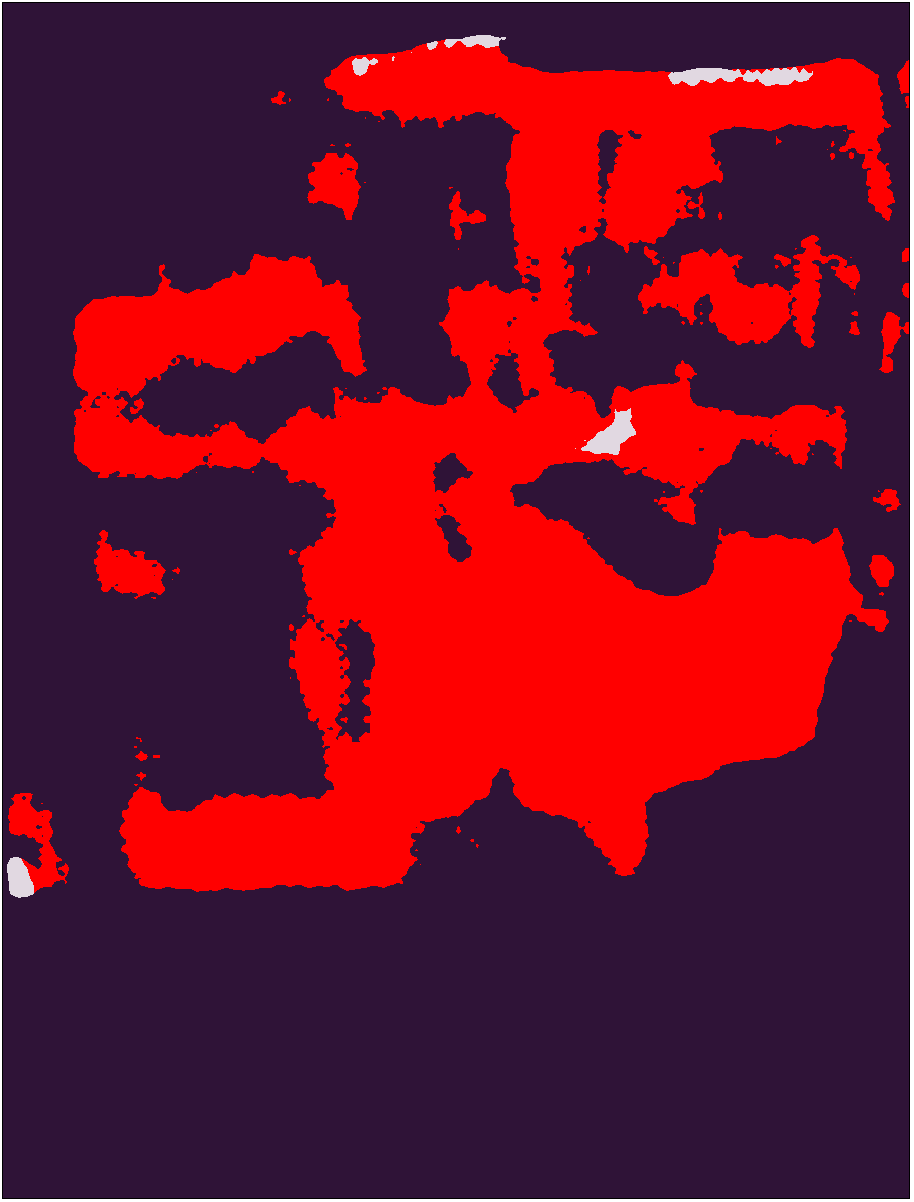

In [8]:

# -----------------------------
# 推論
# -----------------------------
input_dict = {
    utils.BatchKeys.IMAGES: torch.stack([query_image] + support_images).unsqueeze(0),
    utils.BatchKeys.PROMPT_BBOXES: bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_BBOXES:   flag_bboxes.unsqueeze(0),
    utils.BatchKeys.PROMPT_POINTS: points.unsqueeze(0),
    utils.BatchKeys.FLAG_POINTS:   flag_points.unsqueeze(0),
    utils.BatchKeys.PROMPT_MASKS:  masks.unsqueeze(0),
    utils.BatchKeys.FLAG_MASKS:    flag_masks.unsqueeze(0),
    utils.BatchKeys.FLAG_EXAMPLES: flag_examples.unsqueeze(0),
    # DIMS は [query] + [supports] の順に (W,H)
    utils.BatchKeys.DIMS: torch.tensor([all_sizes], dtype=torch.int32),
}
input_dict = dict_to_device(input_dict, device)

with torch.no_grad():
    output = la(input_dict)
logits = output["logits"]
predictions = torch.argmax(logits, dim=1)
predictions.chans


[coco] image02.json (use file_name=image02.png) → bbox:1 point:14 mask:1
b: 1 p: 14 m: 1
bboxes {3: 1}
points {1: 7, 2: 7}
masks {3: 1}


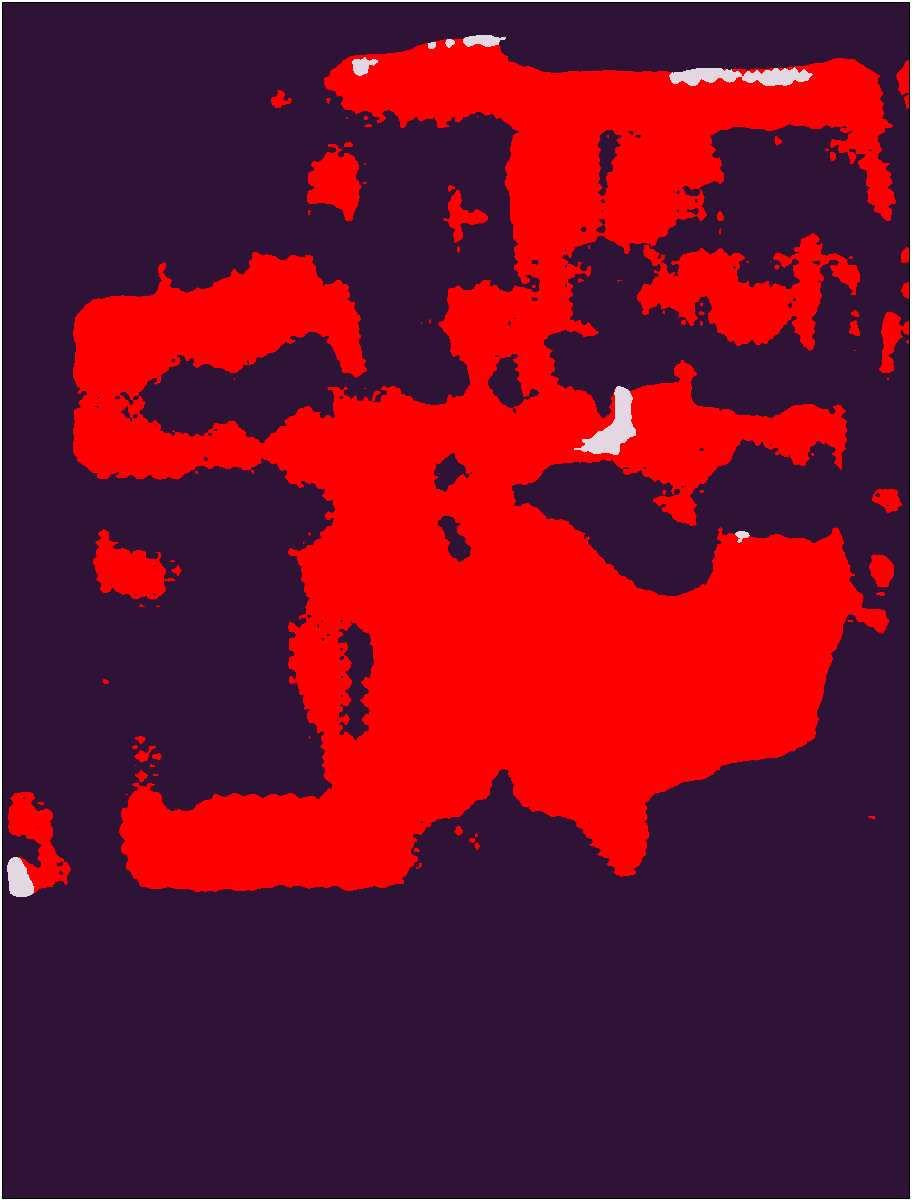

In [9]:
from pathlib import Path
import json
import numpy as np
import cv2

def _mask_from_polygons(size_hw, polygons):
    H, W = int(size_hw[0]), int(size_hw[1])
    m = np.zeros((H, W), dtype=np.uint8)
    for poly in polygons or []:
        if not poly: 
            continue
        pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
        pts = np.round(pts).astype(np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m

def _mask_from_rle(size_hw, counts):
    try:
        from pycocotools import mask as mask_utils
    except Exception:
        raise RuntimeError("RLEを読むには pycocotools が必要です（pip install pycocotools）")
    rle = {"size": [int(size_hw[0]), int(size_hw[1])], "counts": counts}
    m = mask_utils.decode(rle)
    if m.ndim == 3:
        m = m[..., 0]
    return (m.astype(np.uint8) * 255)

def load_ann_any_json(json_path: Path, expected_stem: str | None = None, verbose: bool = True):
    """
    json_path を直接指定して読み込む。COCO形式 / 簡易形式どちらも対応。
    expected_stem を与えると、COCOの images[].file_name と照合し、見つからなければフォールバック。
    返り値: {'bboxes':{cid:[[x1,y1,x2,y2],...]}, 'points':{cid:[[x,y],...]}, 'masks':{cid:[np.ndarray(H,W),...]}}
    """
    out = {"bboxes": {}, "points": {}, "masks": {}}
    if not json_path.exists():
        if verbose: print(f"[ann] not found:", json_path)
        return out

    data = json.load(open(json_path, "r", encoding="utf-8"))
    is_coco = all(k in data for k in ("images","categories","annotations"))

    # --- 簡易形式 ---
    if not is_coco:
        for k in ("bboxes","points"):
            raw = data.get(k, {})
            if isinstance(raw, dict):
                for cid, arr in raw.items():
                    try: cid = int(cid)
                    except: continue
                    if isinstance(arr, list):
                        out[k].setdefault(cid, []).extend(arr)
        raw_masks = data.get("masks", {})
        if isinstance(raw_masks, dict):
            for cid, entries in raw_masks.items():
                try: cid = int(cid)
                except: continue
                for entry in (entries or []):
                    fmt = str(entry.get("format","")).lower()
                    size = entry.get("size", None)
                    if not size: 
                        continue
                    if fmt == "polygons":
                        m = _mask_from_polygons(size, entry.get("polygons", []))
                        out["masks"].setdefault(cid, []).append(m)
                    elif fmt == "rle":
                        m = _mask_from_rle(size, entry.get("counts"))
                        out["masks"].setdefault(cid, []).append(m)
        if verbose:
            tb = sum(len(v) for v in out["bboxes"].values())
            tp = sum(len(v) for v in out["points"].values())
            tm = sum(len(v) for v in out["masks"].values())
            print(f"[simple] {json_path.name} → bbox:{tb} point:{tp} mask:{tm}")
        return out

    # --- COCO形式 ---
    images = data.get("images", [])
    anns   = data.get("annotations", [])
    img_entry = None

    # 1) stem完全一致
    if expected_stem is not None:
        for im in images:
            fn = str(im.get("file_name",""))
            if Path(fn).stem == expected_stem:
                img_entry = im; break

    # 2) フォールバック: 1枚だけならそれを採用
    if img_entry is None and len(images) == 1:
        img_entry = images[0]

    # 3) フォールバック: 部分一致
    if img_entry is None and expected_stem is not None:
        for im in images:
            if expected_stem in Path(str(im.get("file_name",""))).stem:
                img_entry = im; break

    if img_entry is None:
        if verbose:
            print(f"[coco] no image matched. expected_stem={expected_stem} available={[im.get('file_name') for im in images]}")
        return out

    image_id = img_entry["id"]
    H, W = int(img_entry.get("height", 0)), int(img_entry.get("width", 0))
    target_anns = [a for a in anns if a.get("image_id") == image_id]

    def add(dic, cid, v): dic.setdefault(int(cid), []).append(v)

    for a in target_anns:
        cid = int(a.get("category_id"))
        # bbox [x,y,w,h]→[x1,y1,x2,y2]
        if "bbox" in a and isinstance(a["bbox"], (list,tuple)) and len(a["bbox"])==4:
            x,y,w,h = a["bbox"]
            x1,y1,x2,y2 = float(x), float(y), float(x)+float(w), float(y)+float(h)
            if x2>x1 and y2>y1:
                add(out["bboxes"], cid, [x1,y1,x2,y2])
        # keypoints → points
        if "keypoints" in a and isinstance(a["keypoints"], list) and len(a["keypoints"])>=3:
            kps = a["keypoints"]
            for i in range(0,len(kps),3):
                xk, yk, v = kps[i], kps[i+1], kps[i+2]
                if v and xk is not None and yk is not None:
                    add(out["points"], cid, [float(xk), float(yk)])
        # segmentation → masks
        seg = a.get("segmentation", None)
        if seg is not None:
            # RLE
            if isinstance(seg, dict) and "counts" in seg and "size" in seg:
                m = _mask_from_rle(seg["size"], seg["counts"])
                add(out["masks"], cid, m)
            elif isinstance(seg, list) and seg and isinstance(seg[0], dict) and "counts" in seg[0]:
                for r in seg:
                    m = _mask_from_rle(r["size"], r["counts"])
                    add(out["masks"], cid, m)
            # polygons（★空リストは無視！）
            elif isinstance(seg, list) and len(seg)>0:
                m = _mask_from_polygons([H,W], seg)
                if (m>0).any():
                    add(out["masks"], cid, m)

    # 全ゼロマスク除外（保険）
    for cid, arrs in list(out["masks"].items()):
        out["masks"][cid] = [m for m in arrs if isinstance(m, np.ndarray) and (m>0).any()]

    if verbose:
        tb = sum(len(v) for v in out["bboxes"].values())
        tp = sum(len(v) for v in out["points"].values())
        tm = sum(len(v) for v in out["masks"].values())
        print(f"[coco] {json_path.name} (use file_name={img_entry.get('file_name')}) → bbox:{tb} point:{tp} mask:{tm}")
    return out






from pathlib import Path

ANNOT_DIR = Path.cwd() / "annotations"   # 実際の場所に合わせて
json_path = ANNOT_DIR / "image02.json"   # ここを確認
ann = load_ann_any_json(json_path, expected_stem="image02", verbose=True)

print("b:", sum(len(v) for v in ann["bboxes"].values()),
      "p:", sum(len(v) for v in ann["points"].values()),
      "m:", sum(len(v) for v in ann["masks"].values()))
for k in ("bboxes","points","masks"):
    print(k, {cid: len(v) for cid, v in ann[k].items()})







from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))

import os
import json
from typing import Dict, List, Tuple, Any

from PIL import Image
import numpy as np
import cv2
import torch

# Pretty visualizations of tensors
import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo
from torchvision.transforms.functional import resize

from accelerate import Accelerator
from label_anything import LabelAnything
from label_anything.data import get_preprocessing, utils
from label_anything.data.transforms import PromptsProcessor

# -----------------------------
# 可視化ユーティリティ
# -----------------------------
colors = [
    (255, 255, 0),   # yellow
    (255, 0, 0),     # red
    (0, 255, 0),     # green
    (0, 0, 255),     # blue
    (255, 0, 255),   # purple
    (0, 255, 255),   # cyan
    (255, 165, 0),   # orange
    (255, 192, 203), # pink
    (139, 69, 19),   # brown
    (128, 128, 128), # grey
    (0, 0, 0),       # black
] * 3

def draw_masks(img: Image.Image, masks: torch.Tensor, colors):
    masked_image = resize(img.copy(), 256)
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

def draw_boxes(img: Image.Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = map(int, box)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

def draw_points(img: Image.Image, points: torch.Tensor, colors):
    img = np.array(img)
    for i, cat in enumerate(points):
        for point in cat:
            x, y = map(int, point)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

def draw_all(img: Image.Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

def get_image(image_tensor: torch.Tensor) -> Image.Image:
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

def dict_to_device(d, device):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = v.to(device)
        elif isinstance(v, dict):
            d[k] = dict_to_device(v, device)
        elif isinstance(v, list):
            d[k] = [dict_to_device(vv, device) for vv in v]
    return d

# -----------------------------
# すべて JSON 読み込み関連（RLE/Polygonをサポート）
# -----------------------------
ANNOT_DIR = Path.cwd() / "annotations"
CLASS_NAME_TO_ID = {
    "handrail": 1,
    "midrail": 2,
    "baseboard": 3,
    # 日本語名を使うならここに追記可
    "手すり": 1,
    "中桟": 2,
    "巾木": 3,
}

try:
    from pycocotools import mask as mask_utils
except Exception:
    mask_utils = None

def _parse_class_key(k: Any, class_map: Dict[str, int]) -> int:
    """
    JSON のクラスキーを int に正規化。
    - 数字文字列や数値は int に
    - 文字列で handrail/midrail/toeboard（または classes で定義）なら対応 ID に
    """
    if isinstance(k, int):
        return k
    if isinstance(k, str):
        ks = k.strip().lower()
        if ks.isdigit():
            return int(ks)
        if ks in class_map:
            return class_map[ks]
    raise ValueError(f"Unsupported class key: {k}")

def _mask_from_polygons(size_hw: List[int], polygons: List[List[float]]) -> np.ndarray:
    """
    polygons: [[x1,y1,x2,y2,...], ...]
    size_hw: [H, W]
    return: 0/255 の 2値マスク (H, W)
    """
    H, W = int(size_hw[0]), int(size_hw[1])
    m = np.zeros((H, W), dtype=np.uint8)
    for poly in polygons:
        if not poly:
            continue
        pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
        pts = np.round(pts).astype(np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m

def _mask_from_rle(size_hw: List[int], counts) -> np.ndarray:
    """
    COCO RLE をデコードして 0/255 の 2値マスクに。
    counts: 圧縮文字列 or 非圧縮リスト（どちらも COCO 互換）
    pycocotools が無ければ RLE は使えない（polygons を使ってください）。
    """
    if mask_utils is None:
        raise RuntimeError(
            "RLE マスクを使うには pycocotools が必要です。`pip install pycocotools` をインストールするか、"
            "JSON の masks を polygons 形式にしてください。"
        )
    rle = {"size": [int(size_hw[0]), int(size_hw[1])], "counts": counts}
    m = mask_utils.decode(rle)  # (H,W) or (H,W,1)
    if m.ndim == 3:
        m = m[..., 0]
    return (m.astype(np.uint8) * 255)

def _load_mask_entry_json(entry: Any) -> np.ndarray:
    """
    entry:
      - {"format":"rle", "size":[H,W], "counts":"<COCO compressed string>"}
      - {"format":"rle", "size":[H,W], "counts":[...]}  # 非圧縮 RLE リスト
      - {"format":"polygons", "size":[H,W], "polygons":[[x1,y1,...], ...]}
    return: 0/255 の 2値マスク (H, W)
    """
    if not isinstance(entry, dict):
        raise ValueError(f"Mask entry must be dict, got {type(entry)}")

    fmt = str(entry.get("format", "")).lower()
    size = entry.get("size", None)
    if not (isinstance(size, (list, tuple)) and len(size) == 2):
        raise ValueError(f"Mask entry missing valid 'size': {entry}")

    if fmt == "polygons":
        polygons = entry.get("polygons", [])
        return _mask_from_polygons(size, polygons)

    if fmt == "rle":
        counts = entry.get("counts", None)
        if counts is None:
            raise ValueError(f"RLE entry missing 'counts': {entry}")
        return _mask_from_rle(size, counts)

    raise ValueError(f"Unsupported mask format: {fmt}")

def load_annotations_for_image(stem: str) -> Dict[str, Dict[int, list]]:
    """
    annotations/<stem>.json を読み込み、
      - 'bboxes' : {class_id: [[x1,y1,x2,y2], ...]}
      - 'points' : {class_id: [[x,y], ...]}
      - 'masks'  : {class_id: [np.ndarray(H,W;0/255), ...]}  ← JSON 内の RLE/Polygon を 2値マスクに変換
    の形で返す。ファイルが無ければ空辞書を返す。
    """
    ann_path = ANNOT_DIR / f"{stem}.json"
    result = {"bboxes": {}, "points": {}, "masks": {}}
    if not ann_path.exists():
        return result

    with open(ann_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # classes があればマージ（優先: ファイル）
    class_map = dict(CLASS_NAME_TO_ID)
    if "classes" in data and isinstance(data["classes"], dict):
        for name, cid in data["classes"].items():
            try:
                class_map[str(name).strip().lower()] = int(cid)
            except Exception:
                pass

    # bboxes / points をクラスIDキーに正規化
    for k in ["bboxes", "points"]:
        raw = data.get(k, {})
        if isinstance(raw, dict):
            for kk, vv in raw.items():
                cid = _parse_class_key(kk, class_map)
                if not isinstance(vv, list):
                    vv = []
                result[k][cid] = vv

    # masks: JSON内の各エントリを実マスク(np.ndarray)に変換
    raw_masks = data.get("masks", {})
    if isinstance(raw_masks, dict):
        for kk, entries in raw_masks.items():
            cid = _parse_class_key(kk, class_map)
            masks_np = []
            if isinstance(entries, list):
                for entry in entries:
                    m = _load_mask_entry_json(entry)
                    if m is not None:
                        masks_np.append(m.astype(np.uint8))
            result["masks"][cid] = masks_np

    return result

def union_class_ids(dicts_per_support: List[Dict[str, Dict[int, list]]]) -> List[int]:
    s = set()
    for d in dicts_per_support:
        for k in ["bboxes", "points", "masks"]:
            s |= set(d.get(k, {}).keys())
    return sorted(list(s))








# -----------------------------
# モデル/前処理 準備
# -----------------------------
image_size = 1024
custom_preprocess = True

accelerator = Accelerator(cpu=True)
device = accelerator.device

# Label Anything 本体
la = LabelAnything.from_pretrained("pasqualedem/label_anything_sam_1024_coco")

# 画像ロード
img_dir = Path.cwd() / "images"
img_paths = sorted(list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.jpeg")) +
                   list(img_dir.glob("*.png")) + list(img_dir.glob("*.JPG")) + list(img_dir.glob("*.PNG")))
assert len(img_paths) >= 2, "画像はクエリ1 + サポート1以上が必要です（./images に配置）。"

def open_rgb(p: Path) -> Image.Image:
    return Image.open(p).convert("RGB")

# 先頭=クエリ、残り=サポート
query_orig = open_rgb(img_paths[0])
support_orig_images = [open_rgb(p) for p in img_paths[1:]]

# 前処理（LA の transform）
preprocess = get_preprocessing(
    {
        "common": {
            "custom_preprocess": custom_preprocess,
            "image_size": image_size,
        }
    }
)
query_image = preprocess(query_orig)
support_images = [preprocess(img) for img in support_orig_images]

# 画像サイズ（LA内部の tensor 化/正規化用）
support_sizes: List[Tuple[int, int]] = [img.size for img in support_orig_images]   # (W,H)
all_sizes: List[Tuple[int, int]] = [query_orig.size] + support_sizes               # DIMS 用

# プロンプト前処理器
prompts_processor = PromptsProcessor(
    long_side_length=image_size,
    masks_side_length=256,
    custom_preprocess=custom_preprocess,
)






# -----------------------------
# 可視化（任意）
# -----------------------------
drawn_images = [
    draw_all(get_image(img_t), img_masks, img_bboxes, img_points, colors)
    for img_t, img_masks, img_bboxes, img_points in zip(
        support_images, masks, bboxes, points
    )
]
# Image.fromarray(drawn_images[0]).show()  # 必要なら








# -----------------------------
# 推論
# -----------------------------
input_dict = {
    utils.BatchKeys.IMAGES: torch.stack([query_image] + support_images).unsqueeze(0),
    utils.BatchKeys.PROMPT_BBOXES: bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_BBOXES:   flag_bboxes.unsqueeze(0),
    utils.BatchKeys.PROMPT_POINTS: points.unsqueeze(0),
    utils.BatchKeys.FLAG_POINTS:   flag_points.unsqueeze(0),
    utils.BatchKeys.PROMPT_MASKS:  masks.unsqueeze(0),
    utils.BatchKeys.FLAG_MASKS:    flag_masks.unsqueeze(0),
    utils.BatchKeys.FLAG_EXAMPLES: flag_examples.unsqueeze(0),
    # DIMS は [query] + [supports] の順に (W,H)
    utils.BatchKeys.DIMS: torch.tensor([all_sizes], dtype=torch.int32),
}
input_dict = dict_to_device(input_dict, device)

with torch.no_grad():
    output = la(input_dict)
logits = output["logits"]
predictions = torch.argmax(logits, dim=1)
predictions.chans






